11008.0


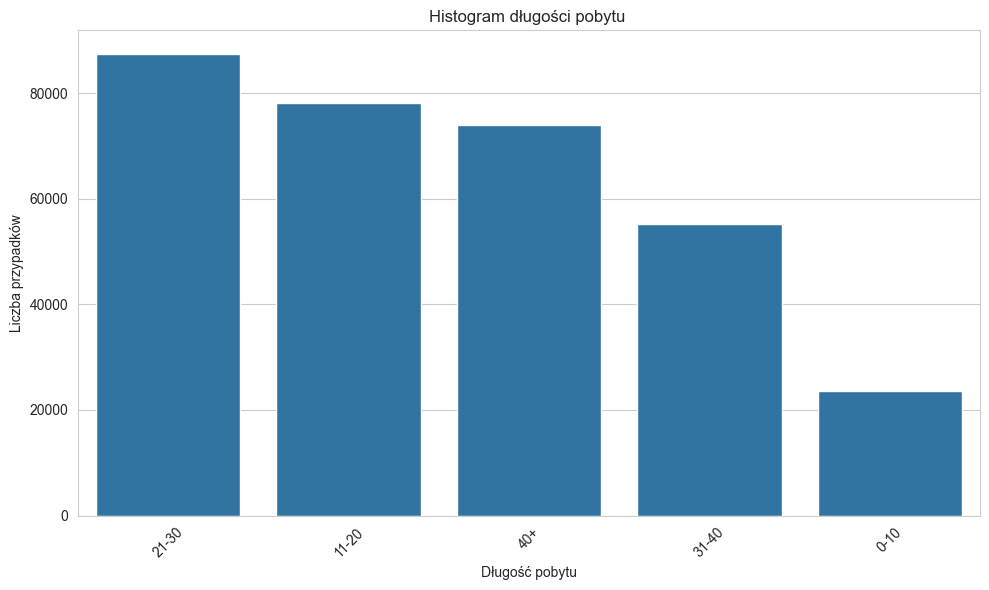

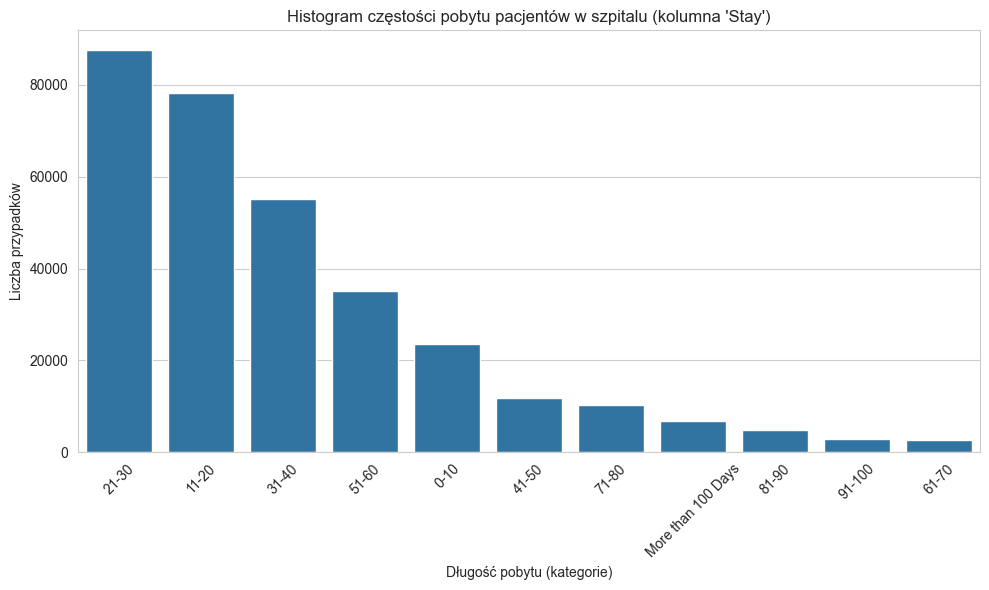

In [14]:
import pandas as pd
df=pd.read_csv("train_data.csv",sep=";")
print(max(df['Admission_Deposit']))
import pandas as pd

# Przykład danych
# df = pd.read_csv("twoj_plik.csv")  # lub masz już df

# Łączenie klas "Stay" powyżej 40 w jedną kategorię "40+"
df['Stay_cleaned'] = df['Stay'].replace({
    '41-50': '40+',
    '51-60': '40+',
    '61-70': '40+',
    '71-80': '40+',
    '81-90': '40+',
    '91-100': '40+',
    'More than 100 Days': '40+'
})
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stay_cleaned', order=df['Stay_cleaned'].value_counts().index)

plt.title("Histogram długości pobytu ")
plt.xlabel("Długość pobytu")
plt.ylabel("Liczba przypadków")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Załaduj dane (załóżmy, że masz je w DataFrame df)
# df = pd.read_csv("twoj_plik.csv")  # jeśli dane są w pliku

# Histogram częstości unikalnych klas (np. "0-10", "11-20", itp.)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stay', order=df['Stay'].value_counts().index)

plt.title("Histogram częstości pobytu pacjentów w szpitalu (kolumna 'Stay')")
plt.xlabel("Długość pobytu (kategorie)")
plt.ylabel("Liczba przypadków")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
